# TensorFlow Cont.

In this tutorial we'll look at the `history` field to examine the model's performance across the training epochs, we'll also take a look at the `callbacks` API that will allow us to do some operations during training.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Setting the random seed
tf.random.set_seed(42)

## Regression Example

### Data Loading

We'll use the boston housing price dataset to train a regression model.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((404, 13), (404,), (102, 13), (102,))

### Model 

The Sequential model has an input layer of shape 13 that matches the number of features in our dataset, with two fairly small hidden layers and finally a single unit output layer with no activation function since we're doing regression.

In [4]:
model = tf.keras.Sequential([
                             tf.keras.layers.Input(13),
                             tf.keras.layers.Dense(16, activation='relu', name='hidden_layer_1'),
                             tf.keras.layers.Dense(8, activation='relu', name='hidden_layer_2'),
                             tf.keras.layers.Dense(1, name='output_layer')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 16)                224       
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 8)                 136       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 9         
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


We'll use `tf.optimizers.Adam()` as the optimizer as we usually do, and we'll use `tf.losses.MeanSquaredError()` as the loss function, alternativly, we can use `tf.losses.MeanAbsoluteError()`.

In [6]:
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError())

Let's fit the model for 100 epoch and examine the results.

In [7]:
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
13/13 [==============================] - 1s 31ms/step - loss: 1963.4778 - val_loss: 1079.7941
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 727.4081 - val_loss: 340.6337
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 191.3203 - val_loss: 188.8812
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 151.2813 - val_loss: 150.5550
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 126.9166 - val_loss: 149.7552
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 127.2338 - val_loss: 142.7907
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 108.6492 - val_loss: 148.9454
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 115.0753 - val_loss: 139.1197
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 123.9533 - val_loss: 129.8227
Epoch 10/100
13/13 [==============================] - 0s 4ms/step - lo

### Examine Model's Training Trends

We can see that in the final epoch, we got a training loss of 41.8860 and a validation loss of 47.4987. While we can take a look at the `fit` method's logs to examine the model's trends while training, it's easier to convert the `history` field in the model to a Pandas `DataFrame` which will allow us to easily filter fields and plot the values.

In [8]:
df = pd.DataFrame(model.history.history)
df

,loss,val_loss
0,1657.922852,1079.794067
1,597.751526,340.633728
2,191.797699,188.881165
3,148.425674,150.554977
4,135.365463,149.755157
...,...,...
95,39.500385,49.833153
96,41.110104,46.794193
97,39.977066,47.242695
98,39.798054,47.582767


We can also use `DataFrame`'s  built-in plot methods to plot the training and validation loss.

Text(0, 0.5, 'Epochs')

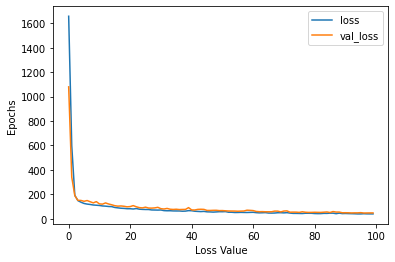

In [9]:
ax = df.plot.line()
ax.set_xlabel("Loss Value")
ax.set_ylabel("Epochs")

We notice that the model has converged quickly and almost stopped improving after the 20th epoch. But the high loss values in the first few epochs may cause imbalance in the line charts. We can zoom into the later part of the epochs using Panda's `iloc` selector 

Text(0, 0.5, 'Epochs')

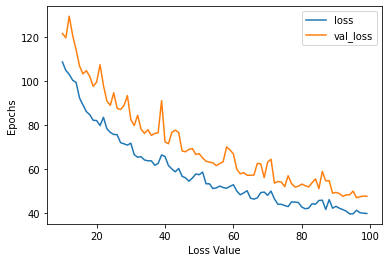

In [10]:
# Here we'll look at the 10th epoch and upwards
ax = df.iloc[10:].plot.line()
ax.set_xlabel("Loss Value")
ax.set_ylabel("Epochs")

After zooming in we can see that the training/validation losses are moving together at the same pace, indicating that there's no overfitting happening, and they also continue to go down even in the last few epochs, which might mean that we can traing beyond 100 epoches and still get better results.

## Regression Example with Callbacks

For this example we'll use the same dataset and model but leverage the `callbacks` parameters in the fit method to implement Early Stopping so we can allow the model to train for more epoches and let it stop automatically when there's no more imporvements

### Restarting Tensorflow State

In [11]:
del tf
import tensorflow as tf
tf.random.set_seed(42)

### Model

In [12]:
model_w_callbacks = tf.keras.Sequential([
                             tf.keras.layers.Input(13),
                             tf.keras.layers.Dense(16, activation='relu', name='hidden_layer_1'),
                             tf.keras.layers.Dense(8, activation='relu', name='hidden_layer_2'),
                             tf.keras.layers.Dense(1, name='output_layer')
])

In [13]:
model_w_callbacks.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 16)                224       
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 8)                 136       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 9         
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_w_callbacks.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError())

### Callbacks

For training, we're adding the callbacks parameter to the `fit` method. This allows us to do custom operations on various events during training like epoch start/end, batch start/end and so on. Let's take a look at a custom callback that we can build.

The callback class below overrides all callback methods and just logs the current loss and accuracy (if exists) values, alternativly we pick only the callback methods that we want to override and leave out the rest. 

Keras has a list of built-in callbacks, we'll be using the EarlyStopping callback, a full list of available callbacks can be found here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

Try editing the above `CustomCallback` class and replace EarlyStopping with it (or add it to the array alongside EarlyStopping, since the `callbacks` parameters takes in an array of callbacks. 



In [15]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

Here, we will use `tf.keras.callbacks.EarlyStopping()` in the callbacks, this callback forces the model to stop training if a certain change threshold isn't met, we can fully control that threshold using the provided parameters.

* `monitor` specifies the metric/loss we're watching, by default it watches the `val_loss`.
* `min_delta` specifies the threshold of change in the monitored metric/loss to continue training.
* `patience` specifies the number of epoches to wait for the desired `min_delta`.
* `mode` specifies the desired direction for change (i.e. increase/decrease), the possible values are either `min`, `max`, or `auto`. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity. baseline: Baseline value for the monitored quantity.




If we set `min_delta` to 0.5, the training will stop when the difference between the last epoch's `val_loss` and the current's is less than 0.5. Adding a patience of 10 will wait for 10 epochs for a change in `val_loss` of 0.5 or more before stopping training.



In [16]:
model_w_callbacks.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=0.5, patience=10)])

Epoch 1/200
13/13 [==============================] - 0s 13ms/step - loss: 1963.4778 - val_loss: 1079.7941
Epoch 2/200
13/13 [==============================] - 0s 4ms/step - loss: 727.4081 - val_loss: 340.6337
Epoch 3/200
13/13 [==============================] - 0s 4ms/step - loss: 191.3203 - val_loss: 188.8812
Epoch 4/200
13/13 [==============================] - 0s 4ms/step - loss: 151.2813 - val_loss: 150.5550
Epoch 5/200
13/13 [==============================] - 0s 4ms/step - loss: 126.9166 - val_loss: 149.7552
Epoch 6/200
13/13 [==============================] - 0s 4ms/step - loss: 127.2338 - val_loss: 142.7907
Epoch 7/200
13/13 [==============================] - 0s 4ms/step - loss: 108.6492 - val_loss: 148.9454
Epoch 8/200
13/13 [==============================] - 0s 4ms/step - loss: 115.0753 - val_loss: 139.1197
Epoch 9/200
13/13 [==============================] - 0s 4ms/step - loss: 123.9533 - val_loss: 129.8227
Epoch 10/200
13/13 [==============================] - 0s 4ms/step - lo

By allowing the model to train for more epoches and leverage EarlyStopping to force the training to stop when there's no more improvements, we got a slightly lower loss (better results) and there doesn't seem to be any overfitting happening during training (mainly due to the simple architecture of the model).

In [17]:
df = pd.DataFrame(model_w_callbacks.history.history)

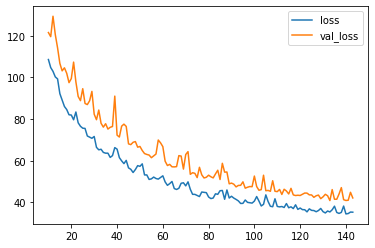

In [18]:
df.iloc[10:].plot.line()